<a href="https://colab.research.google.com/github/Erifai/Bigdata_apache_spark/blob/main/Projet_big_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projet de big data**

## **Mise en place de l’environnement de travail**

### Installation du scikit-learn & matplotlib

In [1]:
#install scikit-learn
 #  ! pip install -U scikit-learn

#install matplotlib
 #  ! pip install -U matplotlib

### installation du spark


Pour exécuter spark dans Colab, nous devons d'abord installer toutes les dépendances dans l'environnement Colab, c'est-à-dire Apache Spark 3.1.1 avec hadoop 2.7, Java 8 et Findspark pour localiser spark dans le système.

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [3]:
!wget -q https://downloads.apache.org/spark/spark-3.1.1/spark-3.1.1-bin-hadoop2.7.tgz


In [4]:
!tar xf spark-3.1.1-bin-hadoop2.7.tgz


In [5]:
!pip install -q findspark

Maintenant que nous avons installé Spark et Java dans Colab, il est temps de définir le chemin d'environnement qui vnous permet d'exécuter Pyspark dans notre environnement Colab.

In [6]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop2.7"

In [7]:
#verfication du type
os.environ["SPARK_HOME"]

'/content/spark-3.1.1-bin-hadoop2.7'

### Creation de Sparkcontext & Sparksession

In [8]:
#SparkContext
#We need to locate Spark in the system. For that, we import findspark and use the findspark.init() method.
import findspark
findspark.init()
from pyspark import SparkContext
sc = SparkContext("local", "my_app")

In [9]:
#SparkSession
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local")\
        .appName("my_app")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

## **Génération de données**

In [10]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
X,y= make_blobs(n_samples=100, centers=3, n_features=2,random_state=0)
Y=[]
for i in range(0,len(y)):
  k=[y[i]]
  Y.append(k)
X = np.append(X, Y, 1)

In [11]:
from pyspark.sql.types import Row
rdd = sc.parallelize(X)
df = rdd.map(lambda c: Row(first_feature=float(c[0]), second_feature=float(c[1]), label=int(c[2]))).toDF()

In [12]:
df.show()

+--------------------+-------------------+-----+
|       first_feature|     second_feature|label|
+--------------------+-------------------+-----+
|   2.631858338047819| 0.6893649043599419|    1|
| 0.08080351735281943|  4.690689825307652|    0|
|   3.002519489206626| 0.7426535668471026|    1|
| -0.6376277690114565|  4.091047047234421|    0|
|-0.07228288652059756|  2.883769390269415|    0|
|  0.6283579292203425|   4.46013629655237|    0|
|  -2.674372665633008| 2.4800622165886885|    2|
| -0.5774832062961446| 3.0054335027183137|    2|
|  2.7275622784453133| 1.3051254961790473|    1|
| 0.34194798486553146|  3.941046161461252|    0|
|  1.7053606407240318| 4.4327702382058005|    0|
|  2.2065607592742156|  5.506167176232801|    0|
|   2.520929961163338|-0.6385800263392869|    1|
|   2.509049292904953| 5.7731460973486755|    0|
| -2.2716588352703453| 2.0914437226741085|    2|
|   3.922826481859448| 1.8037083182133222|    1|
| -1.6253565376473378| 2.2544039749710154|    2|
|   0.16312379650204

In [13]:
X,y= make_blobs(n_samples=200, centers=5, n_features=5,random_state=0)
Y=[]
for i in range(0,len(y)):
  k=[y[i]]
  Y.append(k)
X_old = X
X = np.append(X, Y, 1)
rdd = sc.parallelize(X)
df = rdd.map(lambda c: Row(x1=float(c[0]), x2=float(c[1]), x3=float(c[2]), x4=float(c[3]),x5=float(c[4]),label=int(c[5]))).toDF()
df.show()

+-------------------+-------------------+--------------------+------------------+-------------------+-----+
|                 x1|                 x2|                  x3|                x4|                 x5|label|
+-------------------+-------------------+--------------------+------------------+-------------------+-----+
|  9.737447531579186|  6.579859063057388|-0.00963015514521...| 6.577064878777346| -7.768403717212576|    4|
|   -9.1877177533997| -8.706651939188918|   8.347858743793314| 5.549507509807856|  7.124050957666331|    3|
|  -8.31459870616134|-10.533293810038192|   6.089086872586623| 6.456398445553255|  6.960131670034357|    3|
| 11.349884029749012|  6.486650408782675| -0.7634931991348638|  5.30927631993705|-7.7316191225388735|    4|
| 2.0922085326695736|  5.643240343996315| 0.28783387004372885|1.3220761187662515|-0.4375949681172917|    0|
| 4.0241937913781385|  2.108725192812341|  1.3276401286681156| 8.439950728053807| -8.510625857746506|    2|
| -7.648884964639811|-10.462

## **Analyse descriptive**

### Summary


In [14]:
def describe_pd(df_in, columns, deciles=False):
    if deciles:
        percentiles = np.array(range(0, 110, 10))
    else:
        percentiles = [25, 50, 75]

    percs = np.transpose([np.percentile(df_in.select(x).collect(), percentiles) for x in columns])
    percs = pd.DataFrame(percs, columns=columns)
    percs['summary'] = [str(p) + '%' for p in percentiles]

    spark_describe = df_in.describe().toPandas()
    new_df = pd.concat([spark_describe, percs],ignore_index=True)
    new_df = new_df.round(2)
    return new_df[['summary'] + columns]

num_cols = ['x1','x2','x3','x4','x5']
describe_pd(df,num_cols)

,summary,x1,x2,x3,x4,x5
0,count,200,200,200,200,200
1,mean,2.0352039019903487,0.003699472722128785,3.365045567798552,6.04154518922876,-2.7039139824101306
2,stddev,6.091311749909026,5.597032397504089,3.3505582477661533,3.0546488133009717,5.790982463724554
3,min,-11.150208301693587,-11.552820249640057,-3.225531214536107,-1.0430520160836434,-10.830307128490329
4,max,12.17324601697663,7.818472543729311,9.022730890681093,11.357696900868802,8.966971907049517
5,25%,0.265448,-1.87378,0.633719,4.97216,-7.77074
6,50%,2.79395,0.809423,2.59511,6.29126,-2.82696
7,75%,6.0417,4.64963,6.68047,8.4705,-0.89481


### Histogram

In [15]:
import matplotlib.pyplot as plt
def histo(df,var):
  x = list(df.select(var).toPandas()[var])
  bins = np.arange(-20, 20, 5.0)

  plt.figure(figsize=(5,4))
  # the histogram of the data
  plt.hist(x, bins, alpha=0.8, histtype='bar', color='gold',ec='black',weights=np.zeros_like(x) + 100. / len(x))
  plt.xlabel(var)
  plt.ylabel('percentage')
  plt.xticks(bins)
  plt.show()

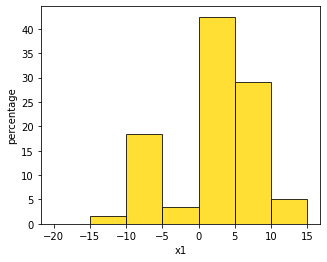

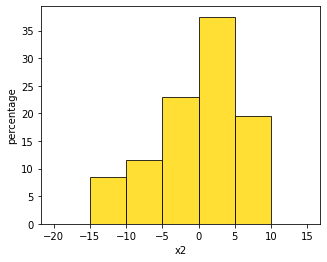

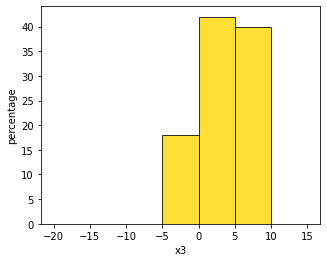

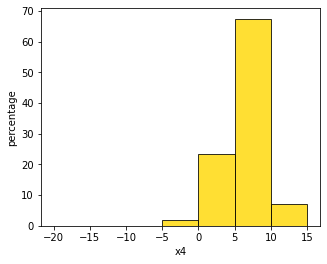

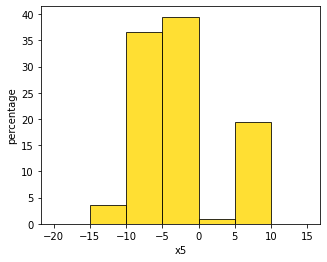

In [16]:
for i in range(1,6):
  histo(df,'x'+str(i))

### Box plot

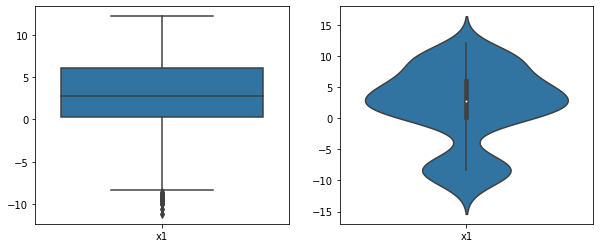

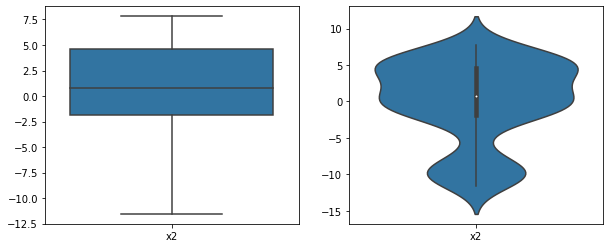

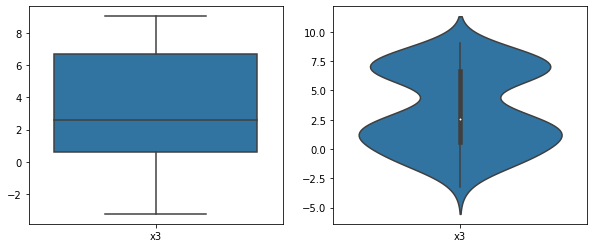

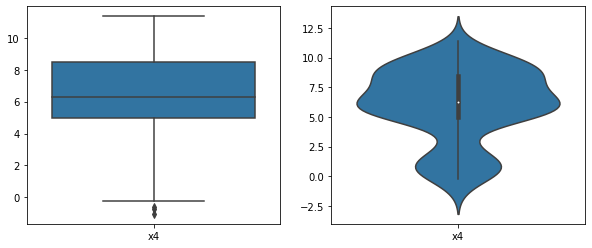

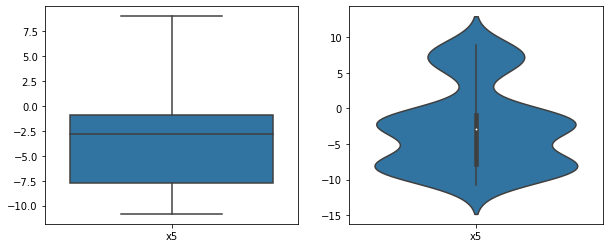

In [17]:
import seaborn as sns
def box_plot(df,var):
  x = df.select(var).toPandas()
  fig = plt.figure(figsize=(10, 4))
  ax = fig.add_subplot(1, 2, 1)
  ax = sns.boxplot(data=x)

  ax = fig.add_subplot(1, 2, 2)
  ax = sns.violinplot(data=x)

for i in range(1,6):
  box_plot(df,'x'+str(i))

### Pie plot

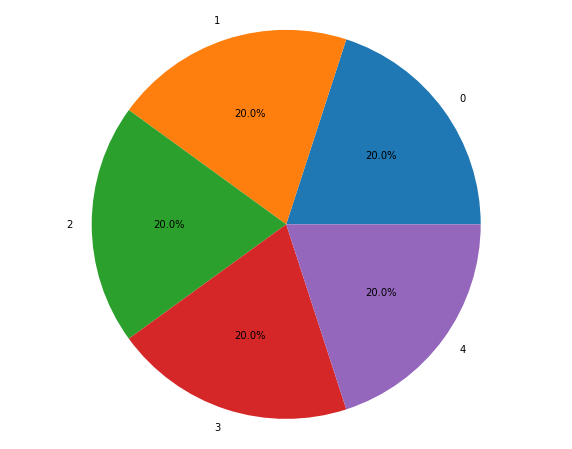

In [18]:
# Data to plot
y = list(df.select('label').toPandas()['label'])
labels = ['0','1','2','3','4']
sizes =  df.select('label').toPandas()['label'].value_counts()
# Plot
plt.figure(figsize=(10,8))
plt.pie(sizes, labels=labels,autopct='%1.1f%%')
plt.axis('equal')
plt.show()

In [19]:
y = df.select('label').toPandas()['label']
print('-------------------------------------------------')
print("Nombre de classe :")
print(len(y.value_counts()))
print('-------------------------------------------------')
print("Nombre d'occurence de chaque classe")
print(y.value_counts())
print('-------------------------------------------------')
print("Vérification du nombre de points")
len(y)

-------------------------------------------------
Nombre de classe :
5
-------------------------------------------------
Nombre d'occurence de chaque classe
4    40
3    40
2    40
1    40
0    40
Name: label, dtype: int64
-------------------------------------------------
Vérification du nombre de points


200

## **Clustering avec des implémentations disponibles**

### K-means sklearn

In [20]:
from time import time
from sklearn.cluster import KMeans
t0 = time() 
kmeans_sk = KMeans(n_clusters=5, random_state=0).fit(X_old)
fit_time_sklearn = time() - t0

print(fit_time_sklearn)


0.032808542251586914


### K-means Spark

In [21]:
#RDD
from pyspark.mllib.clustering import KMeans, KMeansModel

#rdd = df.select('x1', 'x2','x3','x4','x5').rdd.map(lambda x: (x[0], x[1],x[2],x[3],x[4]))
rdd = sc.parallelize(X_old) #X_old c'est les données sans y
t0 = time()
kmeans_rdd = KMeans.train(rdd, 5) # works OK
fit_time_spark_rdd = time() - t0
print(fit_time_spark_rdd)

2.010528326034546


In [22]:
#DATAFRAME
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

vecAssembler = VectorAssembler(inputCols=["x1", "x2","x3","x4","x5"], outputCol="features")
new_df = vecAssembler.transform(df)
t0 = time()
kmeans_df = KMeans(k=5,seed=1).fit(new_df.select('features'))
fit_time_spark_df = time() - t0
transformed = kmeans_df.transform(new_df)
transformed.show()  
print(fit_time_spark_df)


+-------------------+-------------------+--------------------+------------------+-------------------+-----+--------------------+----------+
|                 x1|                 x2|                  x3|                x4|                 x5|label|            features|prediction|
+-------------------+-------------------+--------------------+------------------+-------------------+-----+--------------------+----------+
|  9.737447531579186|  6.579859063057388|-0.00963015514521...| 6.577064878777346| -7.768403717212576|    4|[9.73744753157918...|         0|
|   -9.1877177533997| -8.706651939188918|   8.347858743793314| 5.549507509807856|  7.124050957666331|    3|[-9.1877177533997...|         2|
|  -8.31459870616134|-10.533293810038192|   6.089086872586623| 6.456398445553255|  6.960131670034357|    3|[-8.3145987061613...|         2|
| 11.349884029749012|  6.486650408782675| -0.7634931991348638|  5.30927631993705|-7.7316191225388735|    4|[11.3498840297490...|         0|
| 2.0922085326695736

### Evaluation du clustering

In [23]:
from sklearn.metrics.cluster import normalized_mutual_info_score
# #sklearn :
print('kmeans sklearn nmi score :',normalized_mutual_info_score(y,kmeans_sk.labels_))
# #spark_rdd :

# #spark_df :
print('kmeans dataframe api nmi score :',normalized_mutual_info_score(y,transformed.select('prediction').toPandas()['prediction']))

kmeans sklearn nmi score : 1.0
kmeans dataframe api nmi score : 1.0


### Run time

In [24]:
print('kmeans sklearn :',fit_time_sklearn)
print('kmeans spark rdd :',fit_time_spark_rdd)
print('kmeans spark dataframe :',fit_time_spark_df)




kmeans sklearn : 0.032808542251586914
kmeans spark rdd : 2.010528326034546
kmeans spark dataframe : 4.589735746383667


## **Implémentation de K-means**

In [25]:
X,y= make_blobs(n_samples=10, centers=5, n_features=1,random_state=0)
XX =[]
for i in X:
  XX.append(i[0])
X = XX
points = sc.parallelize(X)
cluster_ids = sc.parallelize(y)
def compute_centroids(points,cluster_ids):
  # RDD sum_by_cluster_id
  def summ(a,b):
    return a+b
  rdd = cluster_ids.zip(points)
  sum_by_cluster_id = rdd.reduceByKey(summ)

  # RDD count_by_cluster_id
  count_by_cluster_id = cluster_ids.map(lambda x : (x, 1)).reduceByKey(summ)
  def moy(a):
    b,c = a
    d,e = b
    f,g = c
    return (d,e/g)

  # RDD de couples (cluster_id, moyenne)
  centroids = sum_by_cluster_id.zip(count_by_cluster_id).map(moy)

  return centroids

centroids = compute_centroids(points,cluster_ids)
for element in centroids.collect():
    print(element)

(1, 4.6839083224970235)
(4, -0.9125929840218963)
(3, 1.4293899763516333)
(2, 3.8682738671961276)
(0, 1.5398702755667988)


In [26]:
from math import sqrt
def squared_distances(x,list_centers):
  list_dist = []
  for y in list_centers:
    list_dist.append(sqrt((x-y)**2))
  return list_dist 

In [27]:
import numpy
def assign_clusters(points,centroids):
  centroids_sorted = centroids.sortByKey()
  list_centers = []
  assign=[]
  for id,center in centroids_sorted.collect():
    list_centers.append(center)
  for x in points.collect():
    assign.append(numpy.argmin(numpy.array(squared_distances(x,list_centers))))
  rdd_assign = sc.parallelize(assign)
  return rdd_assign

rdd_new = assign_clusters(points,centroids)




## **Implémentation K-means ( le cas multidimensionnel)**

In [28]:
#Génération de data multi-dimentionnels

X,y= make_blobs(n_samples=10, centers=5, n_features=3,random_state=0)
li = []
XX = []
X
for i in X:
  for j in i:
    li.append(j)
  XX.append(li)
  li = []
X = XX
#--------------------------------------
points = sc.parallelize(X)
cluster_ids = sc.parallelize(y)
#--------------------------------------

# function compute_centroids adaptée

def compute_centroids(points,cluster_ids):
  def summ(a,b):
    return a+b

  def sum_multi(list1, list2):
    sum = [x + y for (x, y) in zip(list1, list2)]
    return sum
  
  def moy_multi(a):
    b,c = a
    d,e = b
    f,g = c
    return (d,[i/g for i in e])

  rdd = cluster_ids.zip(points)
  sum_by_cluster_id = rdd.reduceByKey(sum_multi)

  # RDD count_by_cluster_id
  count_by_cluster_id = cluster_ids.map(lambda x : (x, 1)).reduceByKey(summ)

  # RDD de couples (cluster_id, moyenne)
  centroids = sum_by_cluster_id.zip(count_by_cluster_id).map(moy_multi)

  return centroids

  
centroids = compute_centroids(points,cluster_ids)
for element in centroids.collect():
    print(element)




(0, [1.9235284711724345, 4.406121721311651, 2.10207539285544])
(1, [0.757569976248603, -2.120188870774235, 2.651252915371458])
(3, [-1.350213469316754, 6.80287533029096, -0.2459992381788279])
(4, [1.7684524856809887, 8.087748327913637, -9.510060310467114])
(2, [-1.345648123222302, 9.3240258812278, 9.874241073859515])


In [29]:
# function squared_distances  adaptée

from math import sqrt
def distance(list1, list2):
    """Distance between two vectors."""
    squares = [(p-q) ** 2 for p, q in zip(list1, list2)]
    return sum(squares) ** .5

def squared_distances(x,list_centers):
  list_dist = []
  for y in list_centers:
    list_dist.append(distance(x,y))
  return list_dist 

# function assign_clusters  adaptée

def assign_clusters(points,centroids):
  centroids_sorted = centroids.sortByKey()
  list_centers = []
  assign=[]
  for id,center in centroids_sorted.collect():
    list_centers.append(center)
  for x in points.collect():
    assign.append(numpy.argmin(numpy.array(squared_distances(x,list_centers))))
  rdd_assign = sc.parallelize(assign)
  return rdd_assign
rdd_new = assign_clusters(points,centroids)

